# Performance Evaluations
* Bootstrap confidence intervals
* Paired bootstrap confidence intervals
* Estimating relationship between AUROC and recall at top K

In [48]:
import os
import sys
import datetime
import pandas as pd
import pickle as pkl
import numpy as np
import lightgbm as lgb
import scipy

import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, average_precision_score

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
sys.path.append('/code')
from edge import data
from edge import patient_stays
from edge import diagnosis
from edge import meds
from edge import vitals
from edge import utils
from edge import perf_utils

# Load previously generated datasets

In [3]:
with open('/data/processed/train_dataset.pkl', 'rb') as f_in: 
    train_data = pkl.load(f_in)
with open('/data/processed/val_dataset.pkl', 'rb') as f_in: 
    val_data = pkl.load(f_in)
with open('/data/processed/test_dataset.pkl', 'rb') as f_in: 
    test_data = pkl.load(f_in)
    
train_X = train_data['X']    
train_Y = train_data['Y']
train_ptimes = train_data['PredictionTimes']

val_X = val_data['X']
val_Y = val_data['Y']
val_ptimes = val_data['PredictionTimes']

test_X = test_data['X']
test_Y = test_data['Y']
test_ptimes = test_data['PredictionTimes']

print(train_X.shape, val_X.shape, test_X.shape)
print(np.mean(train_Y), np.mean(val_Y), np.mean(test_Y))

(8852994, 3677) (1166527, 3677) (860483, 3677)
0.013406763858644883 0.01235805086380341 0.012312852200450213


# Fit a model 
Nothing special, just something to work with... 

In [33]:
train_data = lgb.Dataset(train_X, label=(train_Y))

save_file = '/data/processed/lgb_dataset.bin'
print(f'Saving lgb dataset to {save_file}...')
train_data.save_binary(save_file)

print(f'Loading lgb dataset from {save_file}...')
train_data = lgb.Dataset(save_file)

valid_data = lgb.Dataset(val_X, label=(val_Y))

lgb_params = {
    'boosting': 'gbdt', 
    'objective': 'binary',
    'metric': ['auc', 'binary'],
    'learning_rate': 0.05,  # 0.02, 
    'n_estimators': 3000,
    'max_depth': -1, 
    'num_threads': 32,
    'num_leaves': 63,
    'two_round': True, 
    'early_stopping_rounds': 10,
}

Saving lgb dataset to /data/processed/lgb_dataset.bin...
Loading lgb dataset from /data/processed/lgb_dataset.bin...


In [34]:
model = lgb.train(lgb_params, 
                  train_set=train_data, 
                  valid_sets=[train_data, valid_data])

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's auc: 0.670552	training's binary_logloss: 0.0610133	valid_1's auc: 0.711749	valid_1's binary_logloss: 0.0662433
Training until validation scores don't improve for 10 rounds
[2]	training's auc: 0.68042	training's binary_logloss: 0.0607155	valid_1's auc: 0.721669	valid_1's binary_logloss: 0.065907
[3]	training's auc: 0.685786	training's binary_logloss: 0.0604633	valid_1's auc: 0.7293	valid_1's binary_logloss: 0.0655942
[4]	training's auc: 0.687874	training's binary_logloss: 0.0602366	valid_1's auc: 0.729704	valid_1's binary_logloss: 0.065345
[5]	training's auc: 0.690671	training's binary_logloss: 0.0600369	valid_1's auc: 0.730891	valid_1's binary_logloss: 0.0651266
[6]	training's auc: 0.692991	training's binary_logloss: 0.0598551	valid_1's auc: 0.733279	valid_1's binary_logloss: 0.0649054
[7]	training's auc: 0.695831	training's binary_logloss: 0.0596762	valid_1's auc: 0.734912	valid_1's binary_logloss: 0.0647116
[8]	training's auc: 0.697661	training's binary_logloss: 0.0595

In [47]:
test_Yhat = model.predict(test_X)
print(test_Yhat.shape)

from sklearn.metrics import roc_auc_score, average_precision_score

test_auroc = roc_auc_score(test_Y, test_Yhat)
test_ap = average_precision_score(test_Y, test_Yhat)
saiva_recall = perf_utils.saiva_recall_at_top_K(test_Y, test_Yhat, test_ptimes)
recall = perf_utils.recall_at_top_K(test_Y, test_Yhat, test_ptimes)

print(f"Saiva recall at top 15: {saiva_recall}")
print(f"Recall at top 15: {recall}")
print(f'Test set AUROC: {test_auroc}')
print(f'Test set AUPRC: {test_ap}')


(860483,)
Test set AUROC: 0.765530626906489
Test set AUPRC: 0.03525730078126924
Saiva recall at top 15: 0.4560067681895093
Recall at top 15: 0.37395529108136427


### Conclusion
This looks like we expect - Saiva's formulation of recall should be strictly greater than the standard definition. 

# Bootstrap confidence intervals
Look at CI's from different resampling units - by prediction time (prob wrong), by stay, and by patient. 

## Run random baseline

In [33]:
# Random baseline
random_Yhat = np.random.uniform(size=len(test_Y))
rand_auroc = roc_auc_score(test_Y, random_Yhat)
rand_ap = average_precision_score(test_Y, random_Yhat)
saiva_recall = perf_utils.saiva_recall_at_top_K(test_Y, random_Yhat, test_ptimes)
recall = perf_utils.recall_at_top_K(test_Y, random_Yhat, test_ptimes)

print(f"Saiva recall for random Yhat: {saiva_recall}")
print(f"Standard recall for random Yhat: {recall}")
print(f'Test set AUROC: {rand_auroc}')
print(f'Test set AUPRC: {rand_ap}')


Saiva recall for random Yhat: 0.4572758037225042
Standard recall for random Yhat: 0.16124376389288272
Test set AUROC: 0.4978990423806624
Test set AUPRC: 0.012226887175569507


In [90]:
rand_stats, _ = perf_utils.bootstrap_confidence_intervals(test_Y, random_Yhat, test_ptimes, B=200, sample_by='time')
rand_stats

Estimating confidence intervals from 500 bootstrap samples...
Constructing samples by sampling time...
Running jobs...
Collating statistics


array([[0.35136293, 0.33790803, 0.36431989],
       [0.16077793, 0.15375348, 0.16817582],
       [0.50152881, 0.49580103, 0.50690603],
       [0.01238506, 0.01205922, 0.01270924]])

In [89]:
rand_stats, _ = perf_utils.bootstrap_confidence_intervals(test_Y, random_Yhat, test_ptimes, B=200, sample_by='stay')
rand_stats

Estimating confidence intervals from 500 bootstrap samples...
Constructing samples by sampling stay...
Running jobs...
Collating statistics


array([[0.47617227, 0.45704843, 0.49407413],
       [0.16047685, 0.15264726, 0.16840561],
       [0.50142308, 0.49635828, 0.50731998],
       [0.01238542, 0.0118549 , 0.01293973]])

In [36]:
rand_stats, _ = perf_utils.bootstrap_confidence_intervals(test_Y, random_Yhat, test_ptimes, B=200, sample_by='patient')
rand_stats

Estimating confidence intervals from 200 bootstrap samples...
Constructing samples by sampling patient...
Running jobs...
Collating statistics


,Statistic,Lower CI,Upper CI
Saiva Recall at top K,0.469475,0.451209,0.486661
Recall at top K,0.158805,0.149699,0.167232
AUROC,0.497858,0.492093,0.503399
ave Precision,0.012247,0.011506,0.012934


In [41]:
len(test_Y), len(test_ptimes)

(860483, 860483)

In [44]:
# What if we do things with a new random draw every day? 
really_rand_stats, _ = perf_utils.bootstrap_confidence_intervals(test_Y, None, test_ptimes, B=200, sample_by='patient')
really_rand_stats

Estimating confidence intervals from 200 bootstrap samples...
Constructing samples by sampling patient...
Running jobs...
Collating statistics


,Statistic,Lower CI,Upper CI
Saiva Recall at top K,0.473116,0.453196,0.495984
Recall at top K,0.158494,0.147724,0.168559
AUROC,0.501351,0.492049,0.508589
ave Precision,0.012406,0.011747,0.013073


### Conclusion
There are two issues to de-couple.  First, is Saiva's formulation of recall at top K reasonable?  Second, should we sample by time or by stay/patient? 

* If we resample by time, then the performance of random Yhat appears to drop dramatically from the point estimate from the real data (from 46% to 35%).  This makes models look better. 
* But note that this metric run on model output doesn't seem to do better than randomized - 45.6%.  This is despite the model output dominating clearly in standard recall at top K, AUROC, and aP. 
* For standard recall, AUROC and aP, resampling by time vs stay/patient doesn't matter much - same range.  It seems to only make a difference for Saiva's recall at top K.  
* Doesn't matter whether we use a fixed random Yhat or do random picks every sample - end up quite close to each other, so no material difference.

So overall, I am leaning towards resampling by patient, and noting that Saiva's formulation has some quirks (e.g., probably driven a lot by how many patients there are in each facility).  

## Now run on model output... 
Just in case there is anything different with non-random Yhat... 

In [93]:
# Baseline - point estimates from the data
test_auroc = roc_auc_score(test_Y, test_Yhat)
test_ap = average_precision_score(test_Y, test_Yhat)
saiva_recall = perf_utils.saiva_recall_at_top_K(test_Y, test_Yhat, test_ptimes)
recall = perf_utils.recall_at_top_K(test_Y, test_Yhat, test_ptimes)

print(f"Saiva recall at top 15: {saiva_recall}")
print(f"Recall at top 15: {recall}")
print(f'Test set AUROC: {test_auroc}')
print(f'Test set AUPRC: {test_ap}')

Saiva recall at top 15: 0.4560067681895093
Recall at top 15: 0.37395529108136427
Test set AUROC: 0.765530626906489
Test set AUPRC: 0.03525730078126924


In [94]:
# bootstrap ci's on model output, sample by predictions.  
# Rows are: saiva recall at top 15, recall at top 15, auroc, auprc.  
stats_by_time, stats_time = perf_utils.bootstrap_confidence_intervals(test_Y, test_Yhat, test_ptimes, B=500, sample_by='time')
stats_by_time

Estimating confidence intervals from 500 bootstrap samples...
Constructing samples by sampling time...
Running jobs...
Collating statistics


array([[0.44054958, 0.43081951, 0.4500609 ],
       [0.36457431, 0.3548625 , 0.37461768],
       [0.76551647, 0.76146537, 0.76970295],
       [0.03533058, 0.03421147, 0.03655686]])

In [95]:
stats_by_stay, stats_stay = perf_utils.bootstrap_confidence_intervals(test_Y, test_Yhat, test_ptimes, B=500, sample_by='stay')
stats_by_stay

Estimating confidence intervals from 500 bootstrap samples...
Constructing samples by sampling stay...
Running jobs...
Collating statistics


array([[0.4644339 , 0.44302036, 0.4833846 ],
       [0.36400921, 0.34480653, 0.3827905 ],
       [0.76531016, 0.75535324, 0.7748881 ],
       [0.03525693, 0.03262749, 0.03796868]])

In [96]:
stats_by_patient, stats_patient = perf_utils.bootstrap_confidence_intervals(test_Y, test_Yhat, test_ptimes, B=500, sample_by='patient')
stats_by_patient

Estimating confidence intervals from 500 bootstrap samples...
Constructing samples by sampling patient...
Running jobs...
Collating statistics


array([[0.4653694 , 0.44377684, 0.48825996],
       [0.36480567, 0.34575983, 0.38505555],
       [0.76546462, 0.75525232, 0.7755082 ],
       [0.03526932, 0.03234354, 0.03818741]])

# Conclusion
Reinforces conclusion that the Saiva recall metric is problematic.

Default for confidence intervals should be to resample by patient. 

# Paired Bootstrap confidence intervals
Given a pair of models, get confidence intervals on the difference, paired for greater power. 

In [97]:
# Use random as a baseline
ci_results, raw_stats = perf_utils.paired_bootstrap_confidence_intervals(test_Y, 
                                                                         random_Yhat, 
                                                                         test_Yhat, 
                                                                         test_ptimes, 
                                                                         B=500, 
                                                                         sample_by='patient')
ci_results

Constructing samples by sampling patient...
Running jobs...
Collating statistics


array([[-0.0021704 , -0.02690509,  0.02426145],
       [ 0.20858906,  0.18899829,  0.22854717],
       [ 0.2649961 ,  0.25299446,  0.27641833],
       [ 0.02316093,  0.02081499,  0.02601038]])

# Relationship between AUROC, aP, and recall at top K.  
Look at this empirically, using models that are stopped early to get different performance characteristics.  We'll do this by stopping training at various points.  From prior run, seems like we can do this at: 

1, 5, 11, 23, 40, 72, 126


In [20]:
num_iter = [1, 4, 6, 12, 17, 32, 54]
#num_iter = [1, 5]
model_list = []
yhat_list = []
stats_list = []
init_model = None

lgb_params = {
    'boosting': 'gbdt', 
    'objective': 'binary',
    'metric': ['auc', 'binary'],
    'learning_rate': 0.05,  # 0.02, 
    'max_depth': -1, 
    'num_threads': 32,
    'num_leaves': 63,
    'two_round': True, 
}

In [21]:
train_data = lgb.Dataset(train_X, label=(train_Y), free_raw_data=False)
valid_data = lgb.Dataset(val_X, label=(val_Y), free_raw_data=False)
for num_boost_round in num_iter: 
    print(f"Fitting for {num_boost_round} rounds")
    model = lgb.train(lgb_params, 
                      train_set=train_data, 
                      num_boost_round=num_boost_round, 
                      init_model=init_model, 
                      valid_sets=[train_data, valid_data])
    print(f"Getting Yhat...")
    yhat = model.predict(test_X)
    print("Calculating perf stats...")
    stats, _ = perf_utils.bootstrap_confidence_intervals(test_Y, yhat, test_ptimes)

    model_list.append(model)
    yhat_list.append(yhat)
    stats_list.append(stats)
    
    init_model = model

Fitting for 1 rounds
[1]	training's auc: 0.679947	training's binary_logloss: 0.0706799	valid_1's auc: 0.719574	valid_1's binary_logloss: 0.0661988
Getting Yhat...
Calculating perf stats...
Estimating confidence intervals from 200 bootstrap samples...
Constructing samples by sampling patient...
Running jobs...
Collating statistics
Fitting for 4 rounds
[2]	training's auc: 0.686307	training's binary_logloss: 0.0703037	valid_1's auc: 0.726896	valid_1's binary_logloss: 0.0658296
[3]	training's auc: 0.690692	training's binary_logloss: 0.0699816	valid_1's auc: 0.729423	valid_1's binary_logloss: 0.0655198
[4]	training's auc: 0.695939	training's binary_logloss: 0.0696942	valid_1's auc: 0.734093	valid_1's binary_logloss: 0.0652455
[5]	training's auc: 0.698092	training's binary_logloss: 0.069439	valid_1's auc: 0.736235	valid_1's binary_logloss: 0.0649889
Getting Yhat...
Calculating perf stats...
Estimating confidence intervals from 200 bootstrap samples...
Constructing samples by sampling patient

In [ ]:
stats_list[0]

In [86]:
# Manually put in statistics for all features (including stay but without cheat feature)
raw_stats = [[52.7, 50.7, 54.7], [45.8, 43.8, 47.8], [82.8, 82.0, 83.6], [5.9, 5.32, 6.54]] 
raw_stats = np.array(raw_stats) / 100.
all_features_stats = pd.DataFrame(raw_stats)
all_features_stats.index = ['Saiva Recall at top K', 'Recall at top K', 'AUROC', 'ave Precision']
all_features_stats.columns = ['Statistic', 'Lower CI', 'Upper CI']
all_features_stats

,Statistic,Lower CI,Upper CI
Saiva Recall at top K,0.527,0.5070,0.5470
Recall at top K,0.458,0.4380,0.4780
AUROC,0.828,0.8200,0.8360
ave Precision,0.059,0.0532,0.0654


In [46]:
rand_stats = pd.DataFrame(really_rand_stats)
rand_stats.index = ['Saiva Recall at top K', 'Recall at top K', 'AUROC', 'ave Precision']
rand_stats.columns = ['Statistic', 'Lower CI', 'Upper CI']
rand_stats

,Statistic,Lower CI,Upper CI
Saiva Recall at top K,0.473116,0.453196,0.495984
Recall at top K,0.158494,0.147724,0.168559
AUROC,0.501351,0.492049,0.508589
ave Precision,0.012406,0.011747,0.013073


### Make cheat dataset so we can extrapolate beyond all_features_stats
This isn't a great estimate but it gets the point across well enough... 

In [52]:
stay_features = scipy.sparse.load_npz('/data/processed/stay_features_csr_cheat.npz')
print(stay_features.shape)

with open("/data/processed/prediction_times.pkl", 'rb') as f_in: 
    prediction_times = pkl.load(f_in)
print(prediction_times.shape)

stays = pd.read_parquet('/data/raw/stays.parquet')

indices = prediction_times.StayRowIndex.values
dates_of_transfer = stays.DateOfTransfer.dt.date.values[indices]
prediction_dates = prediction_times.PredictionTimestamp.dt.date.values
time_diffs = [ transfer_date - predict_date for transfer_date, predict_date in zip(dates_of_transfer, prediction_dates)]
time_diffs_in_days = [diff.days if type(diff) is datetime.timedelta else 1e6 for diff in time_diffs]

time_diffs_in_days = np.array(time_diffs_in_days)
print(np.sum(time_diffs_in_days <= 4))
print(np.mean(time_diffs_in_days <= 4))

mask = (time_diffs_in_days <= 4)
target = np.zeros(len(time_diffs_in_days))
target[mask] = 1
print(np.mean(target))

train_start_date = '2017-01-01'
train_end_date = '2019-07-31'
val_end_date = '2019-11-30'
test_end_date = '2020-02-28'

stay_indices = prediction_times.StayRowIndex.values
start_dates = stays.StartDate[stay_indices]
td = pd.to_timedelta('90 days')
min_date = pd.Timestamp(train_start_date) + td
print(min_date)

print('Getting masks')
train_mask = (prediction_times.PredictionTimestamp.dt.date.values >= min_date) & \
             (prediction_times.PredictionTimestamp.dt.date.values <= pd.to_datetime(train_end_date))
val_mask = (prediction_times.PredictionTimestamp.dt.date.values > pd.to_datetime(train_end_date)) & \
           (prediction_times.PredictionTimestamp.dt.date.values <= pd.to_datetime(val_end_date))
test_mask = prediction_times.PredictionTimestamp.dt.date.values > pd.to_datetime(val_end_date)
np.sum(train_mask), np.sum(val_mask), np.sum(test_mask)

train_X = stay_features[train_mask,:]
train_Y = target[train_mask]
train_ptimes = prediction_times[train_mask]
train_ptimes = train_ptimes.reset_index(drop=True)
print(train_X.shape)

val_X = stay_features[val_mask,:]
val_Y = target[val_mask]
val_ptimes = prediction_times[val_mask]
val_ptimes = val_ptimes.reset_index(drop=True)
print(val_X.shape)

test_X = stay_features[test_mask,:]
test_Y = target[test_mask]
test_ptimes = prediction_times[test_mask]
test_ptimes = test_ptimes.reset_index(drop=True)
print(test_X.shape)

print(np.mean(train_Y), np.mean(val_Y), np.mean(test_Y))


(10880004, 7)
(10880004, 4)
143701
0.013207807644188366
0.013207807644188366
2017-04-01 00:00:00
Getting masks
(8028758, 7)
(1166527, 7)
(860483, 7)
0.013063788944691072 0.01235805086380341 0.012312852200450213


In [53]:
# Fit model to completion so we can eyeball num iterations.
train_data = lgb.Dataset(train_X, label=(train_Y))
valid_data = lgb.Dataset(val_X, label=(val_Y))


model = lgb.train(lgb_params, 
                  train_set=train_data, 
                  valid_sets=[valid_data])

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's auc: 0.814405	valid_0's binary_logloss: 0.0651803
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.835256	valid_0's binary_logloss: 0.0641312
[3]	valid_0's auc: 0.838543	valid_0's binary_logloss: 0.0632586
[4]	valid_0's auc: 0.839793	valid_0's binary_logloss: 0.0625328
[5]	valid_0's auc: 0.842539	valid_0's binary_logloss: 0.0618271
[6]	valid_0's auc: 0.842997	valid_0's binary_logloss: 0.0612539
[7]	valid_0's auc: 0.843237	valid_0's binary_logloss: 0.0607414
[8]	valid_0's auc: 0.843989	valid_0's binary_logloss: 0.06025
[9]	valid_0's auc: 0.844056	valid_0's binary_logloss: 0.0598435
[10]	valid_0's auc: 0.844797	valid_0's binary_logloss: 0.0594602
[11]	valid_0's auc: 0.846002	valid_0's binary_logloss: 0.0590901
[12]	valid_0's auc: 0.847259	valid_0's binary_logloss: 0.0587519
[13]	valid_0's auc: 0.858487	valid_0's binary_logloss: 0.0584404
[14]	valid_0's auc: 0.861312	valid_0's binary_logloss: 0.0581472
[15]	valid_0's auc: 0.861929	valid_0's b

In [ ]:
# Okay, now generate stats
num_iter = [5, 7, 12, 50]
init_model = None
lgb_params = {
    'boosting': 'gbdt', 
    'objective': 'binary',
    'metric': ['auc', 'binary'],
    'learning_rate': 0.05,  # 0.02, 
    'max_depth': -1, 
    'num_threads': 32,
    'num_leaves': 7,
    'two_round': True, 
}

train_data = lgb.Dataset(train_X, label=(train_Y), free_raw_data=False)
valid_data = lgb.Dataset(val_X, label=(val_Y), free_raw_data=False)
for num_boost_round in num_iter: 
    print(f"Fitting for {num_boost_round} rounds")
    model = lgb.train(lgb_params, 
                      train_set=train_data, 
                      num_boost_round=num_boost_round, 
                      init_model=init_model, 
                      valid_sets=[train_data, valid_data])
    print(f"Getting Yhat...")
    yhat = model.predict(test_X)
    print("Calculating perf stats...")
    stats, _ = perf_utils.bootstrap_confidence_intervals(test_Y, yhat, test_ptimes)
    stats_list.append(stats)
    
    init_model = model


In [59]:
stats_list[0]

,Statistic,Lower CI,Upper CI
Saiva Recall at top K,0.529418,0.505697,0.548370
Recall at top K,0.331676,0.314922,0.348412
AUROC,0.731222,0.721613,0.740196
ave Precision,0.031449,0.028585,0.034450


## Make plots

### Plot - Saiva recall and recall as function of AUROC
Point of this plot is to point out some non-intuitive properties of Saiva recall with respect to performance against random baseline. 

In [88]:
stats_list.append(all_features_stats)

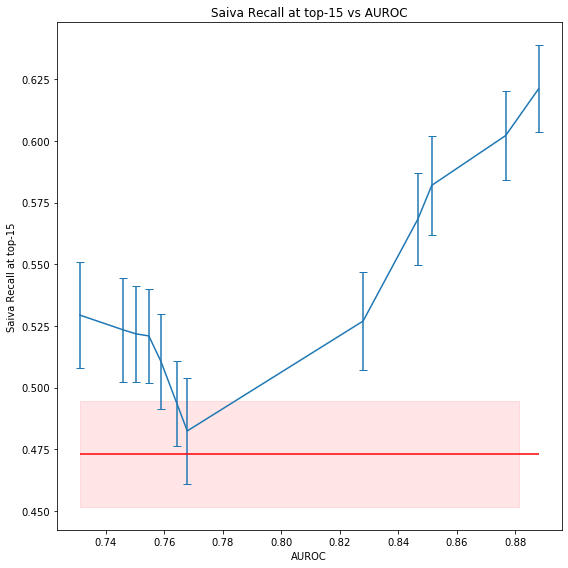

In [103]:
stat_name = 'Saiva Recall at top K'
statistics, aurocs, errs = [], [], []
for stats_df in stats_list: 
    stats_record = stats_df.loc[stat_name]
    statistics.append(stats_record.Statistic)
    aurocs.append(stats_df.loc['AUROC'].Statistic)
    errs.append((stats_record['Upper CI'] - stats_record['Lower CI'])/2.)

rand_record = rand_stats.loc[stat_name]
rand_pt_est = rand_record.Statistic
rand_err = (rand_record['Upper CI'] - rand_record['Lower CI']) / 2.

statistics = np.array(statistics)
aurocs = np.array(aurocs)
errs = np.array(errs)

indices = np.argsort(aurocs)
statistics = statistics[indices]
aurocs = aurocs[indices]
errs = errs[indices]

# print(indices)
# print(aurocs)
# print(statistics)
# print(errs)

fig, ax = plt.subplots(figsize=(8,8))
ax.errorbar(aurocs, statistics, yerr=errs, capsize=4)#lolims=True, uplims=True)
plt.xlabel('AUROC')
plt.ylabel('Saiva Recall at top-15')
plt.title('Saiva Recall at top-15 vs AUROC')

ax.hlines(y=rand_pt_est, xmin=np.min(aurocs), xmax=np.max(aurocs), colors='r')

x = np.arange(np.min(aurocs), np.max(aurocs), 0.01)
y1 = rand_pt_est - rand_err
y2 = rand_pt_est + rand_err
ax.fill_between(x, y1, y2, color='r', alpha=0.1)

fig.tight_layout()


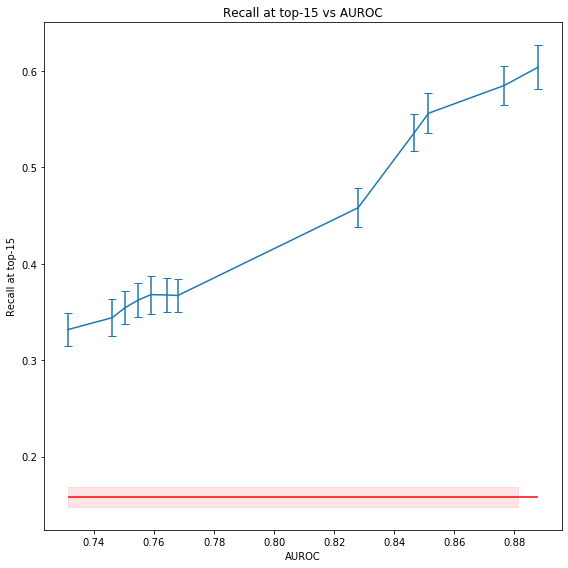

In [104]:
stat_name = 'Recall at top K'
statistics, aurocs, errs = [], [], []
for stats_df in stats_list: 
    stats_record = stats_df.loc[stat_name]
    statistics.append(stats_record.Statistic)
    aurocs.append(stats_df.loc['AUROC'].Statistic)
    errs.append((stats_record['Upper CI'] - stats_record['Lower CI'])/2.)

rand_record = rand_stats.loc[stat_name]
rand_pt_est = rand_record.Statistic
rand_err = (rand_record['Upper CI'] - rand_record['Lower CI']) / 2.

statistics = np.array(statistics)
aurocs = np.array(aurocs)
errs = np.array(errs)

indices = np.argsort(aurocs)
statistics = statistics[indices]
aurocs = aurocs[indices]
errs = errs[indices]

# print(indices)
# print(aurocs)
# print(statistics)
# print(errs)

fig, ax = plt.subplots(figsize=(8,8))
ax.errorbar(aurocs, statistics, yerr=errs, capsize=4)#lolims=True, uplims=True)
plt.xlabel('AUROC')
plt.ylabel('Recall at top-15')
plt.title('Recall at top-15 vs AUROC')

ax.hlines(y=rand_pt_est, xmin=np.min(aurocs), xmax=np.max(aurocs), colors='r')

x = np.arange(np.min(aurocs), np.max(aurocs), 0.01)
y1 = rand_pt_est - rand_err
y2 = rand_pt_est + rand_err
ax.fill_between(x, y1, y2, color='r', alpha=0.1)

fig.tight_layout()

### Plot - all stats, different feature sets
Point of this is to show a bit of progress with features, and to show current state (and also value of stays features). 

In [107]:
all_features_stats

,Statistic,Lower CI,Upper CI
Saiva Recall at top K,0.527,0.5070,0.5470
Recall at top K,0.458,0.4380,0.4780
AUROC,0.828,0.8200,0.8360
ave Precision,0.059,0.0532,0.0654


In [111]:
stay_features_stats = [[47.7, 45.8, 49.6], 
                       [43.6, 41.5, 45.7], 
                       [80.8, 79.9, 81.7], 
                       [5.63, 5.03, 6.20]]
stay_features_stats = pd.DataFrame(np.array(stay_features_stats) / 100.)
stay_features_stats.index = ['Saiva Recall at top K', 'Recall at top K', 'AUROC', 'ave Precision']
stay_features_stats.columns = ['Statistic', 'Lower CI', 'Upper CI']
stay_features_stats

,Statistic,Lower CI,Upper CI
Saiva Recall at top K,0.4770,0.4580,0.496
Recall at top K,0.4360,0.4150,0.457
AUROC,0.8080,0.7990,0.817
ave Precision,0.0563,0.0503,0.062


In [112]:
old_features_stats = [[0.4653694 , 0.44377684, 0.48825996],
                      [0.36480567, 0.34575983, 0.38505555],
                      [0.76546462, 0.75525232, 0.7755082 ],
                      [0.03526932, 0.03234354, 0.03818741]]
old_features_stats = pd.DataFrame(np.array(old_features_stats))
old_features_stats.index = ['Saiva Recall at top K', 'Recall at top K', 'AUROC', 'ave Precision']
old_features_stats.columns = ['Statistic', 'Lower CI', 'Upper CI']
old_features_stats

,Statistic,Lower CI,Upper CI
Saiva Recall at top K,0.465369,0.443777,0.488260
Recall at top K,0.364806,0.345760,0.385056
AUROC,0.765465,0.755252,0.775508
ave Precision,0.035269,0.032344,0.038187


In [126]:
stats_for_features = [rand_stats, 
                      old_features_stats, 
#                      stay_features_stats, 
                      all_features_stats]
set_names = ['random', 
             'dx, rx, vitals', 
#             'stays', 
             'all']

In [138]:
# Make barplot with error bars... 
def make_barplot(stat_name, stats_list, names): 
    feature_sets = names
    statistics, errs = [], []
    for stats_df in stats_for_features: 
        stats_record = stats_df.loc[stat_name]
        statistics.append(stats_record.Statistic)
        errs.append((stats_record['Upper CI'] - stats_record['Lower CI'])/2.)

    statistics = np.array(statistics)
    errs = np.array(errs)
    x_pos = np.arange(len(feature_sets))

    fig, ax = plt.subplots(figsize=(4,4))
    ax.bar(x_pos, statistics, yerr=errs, capsize=4, align='center', alpha=0.5)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(feature_sets)
    plt.xlabel('Feature Set')
    plt.ylabel(stat_name)
    plt.title(stat_name)

    fig.tight_layout()


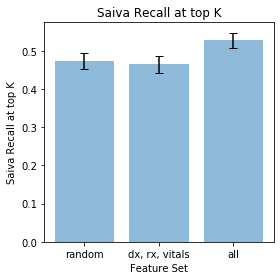

In [139]:
make_barplot('Saiva Recall at top K', 
             stats_for_features, 
             set_names)


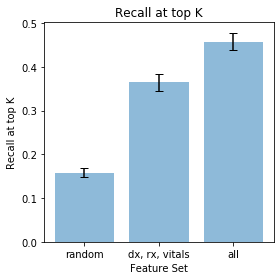

In [140]:
make_barplot('Recall at top K', 
             stats_for_features, 
             set_names)

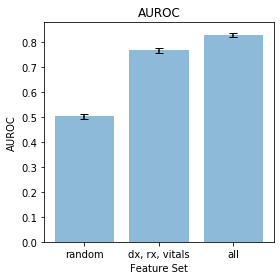

In [141]:
make_barplot('AUROC', 
             stats_for_features, 
             set_names)

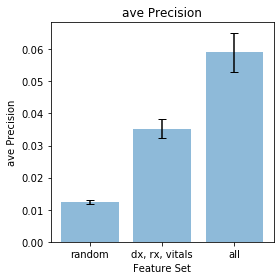

In [142]:
make_barplot('ave Precision', 
             stats_for_features, 
             set_names)

In [125]:
# Make a plot... 
auroc, recall, recall_ci = [], [], []
saiva_recall, saiva_recall_ci = [], []
for stats in stats_list: 
    auroc.append(stats[2,0])
    
    # Standard recall at top K
    pt_est = stats[1,0]
    recall.append(pt_est)
    ci = np.array([stats[1,1], stats[1,2]])
    ci_abs_diffs = np.abs(ci - pt_est)
    ci_mean_abs_diff = np.mean(ci_abs_diffs)
    recall_ci.append(ci_mean_abs_diff)

    # Saiva recall at top K
    pt_est = stats[0,0]
    saiva_recall.append(pt_est)
    ci = np.array([stats[0,1], stats[0,2]])
    ci_abs_diffs = np.abs(ci - pt_est)
    ci_mean_abs_diff = np.mean(ci_abs_diffs)
    saiva_recall_ci.append(ci_mean_abs_diff)

                         

In [126]:
auroc, recall, recall_ci

([0.7162071826811832,
  0.7354829513833424,
  0.7487888981176473,
  0.7511907026972066,
  0.7565258627755704,
  0.7619880107989502,
  0.7676641866274617,
  0.7692780024526167],
 [0.3278969940174345,
  0.33873332492569325,
  0.3469002185489191,
  0.3570786960932293,
  0.3663142382865749,
  0.37031547947930904,
  0.37625242380783674,
  0.37413970765036675],
 [0.015442501777846646,
  0.014680994768842603,
  0.017759819778138314,
  0.017302631932384654,
  0.01696054553195317,
  0.018819554682407202,
  0.019884739452850714,
  0.021343643140343732])

In [127]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,8))
ax.errorbar(auroc, recall, yerr=recall_ci)
ax.title('Recall at top-K vs AUROC')

ModuleNotFoundError: No module named 'matplotlib'

In [128]:
auroc, saiva_recall, saiva_recall_ci

([0.7162071826811832,
  0.7354829513833424,
  0.7487888981176473,
  0.7511907026972066,
  0.7565258627755704,
  0.7619880107989502,
  0.7676641866274617,
  0.7692780024526167],
 [0.5276393294971511,
  0.5244628423547301,
  0.5173273004028403,
  0.5240016676237786,
  0.5254388985471894,
  0.5153374685200527,
  0.49928701178608675,
  0.48742410809633235],
 [0.01841280382613869,
  0.01965310228940248,
  0.02040490057306274,
  0.018334533102394468,
  0.01891218670523165,
  0.020880317191525805,
  0.020274487326373852,
  0.019163270213468753])

In [129]:
# Argh - matplotlib is not in the container, so for convenience, making plots in avante-3-day-hosp container.  Ugh. 

In [131]:
data_dict['stays']

NameError: name 'data_dict' is not defined